In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import flow.visualize.visualize_ring as visualize_ring

import torch

# Anti-Flow specific functions for  detection:
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

from detector_dev.utils import run_ring_sim_variable_cfm,Bando_OVM_FTL

from Adversaries.controllers.car_following_adversarial import ACC_Benign

import detector_dev.utils as utils

import Data_Processing.sim_processing_utils as sim_processing_utils

from Data_Processing.sim_processing_utils import get_trajectory_timeseries

from importlib import reload

print('Libraries loaded.')

Libraries loaded.


In [2]:
import misc
reload(misc)
from misc import sim_attacker_follows_smoother,sim_attacker_precedes_smoother,sim_only_HVs

In [3]:
trajectory_dict_all_human,emission_path_HVs = sim_only_HVs()

Number of classes of driver: 40
Running ring simulation, ring length: 500


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1028.871234224037
data/ring_variable_cfm_20230119-1416581674159418.477118-0_emission.csv data
Average, std velocities: 5.776532332921224, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1028.871234224037, 0.0
Total time: 19.685699224472046
steps/second: 116.33459141308282
Data loaded, total time: 0.8620350360870361


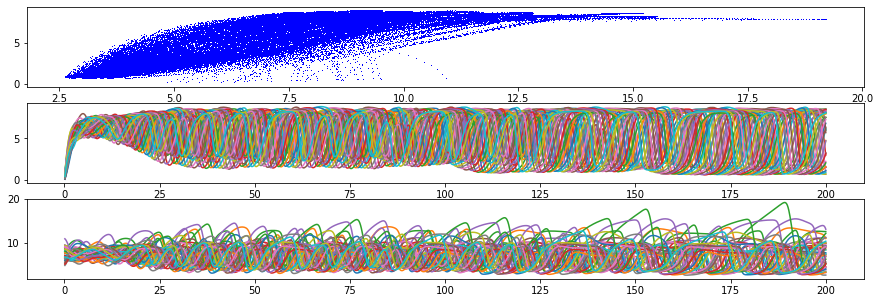

In [4]:
begin_time = 0.0
end_time = 500.0

veh_ids = (trajectory_dict_all_human.keys())
plt.figure(figsize=[15,5])

plt.subplot(3,1,1)

for veh_id in veh_ids:
    time = trajectory_dict_all_human[veh_id][:,0]
    index_select = np.logical_and(time>begin_time,time<end_time)
    
    time = time[index_select]
    
    speed = trajectory_dict_all_human[veh_id][:,1]
    spacing = trajectory_dict_all_human[veh_id][:,2]
    
    speed = speed[index_select]
    spacing = spacing[index_select]
    
    plt.subplot(3,1,1)
    plt.plot(spacing,speed,'b,')
    
    plt.subplot(3,1,2)
    plt.plot(time,speed)
    
    plt.subplot(3,1,3)
    plt.plot(time,spacing)

In [5]:
import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X

import torch

# Anti-Flow specific functions for  detection:

from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

print('Imported detection libraries.')

Imported detection libraries.


In [41]:
from copy import deepcopy

def make_timeseries_list(trajectory_dict):
    timeseries_list = []
    for veh_id in trajectory_dict:
        trajectory_samples = []
        trajectory_data = trajectory_dict[veh_id]
        
        speed = trajectory_data[:,1]
        accel = np.gradient(speed,.1)
        head_way = trajectory_data[:,2]
        rel_vel = trajectory_data[:,3]
        
        trajectory_samples.append(speed)
        trajectory_samples.append(accel)
        trajectory_samples.append(head_way)
        trajectory_samples.append(rel_vel)
        
        timeseries_list.append(trajectory_samples)
    return timeseries_list


def make_timeseries_list_normalized(trajectory_dict,normalizing_factors=None):
    timeseries_list_non_normalized = make_timeseries_list(trajectory_dict)
    num_timeseries = len(timeseries_list_non_normalized[0])

    if(normalizing_factors is None):
        normalizing_factors = np.zeros(num_timeseries,)
        
        for t_list in timeseries_list_non_normalized:
            for i in range(num_timeseries):
                max_abs_val = np.max(np.abs(t_list[i]))
                if(max_abs_val > normalizing_factors[i]): normalizing_factors[i] = max_abs_val
    
    normalized_timeseries_list = []
    
    for t_list in timeseries_list_non_normalized:
        t_list_normed = deepcopy(t_list)
        for i in range(num_timeseries):
            t_list_normed[i] = t_list_normed[i]/normalizing_factors[i]
        normalized_timeseries_list.append(t_list_normed)
            
    return normalized_timeseries_list,normalizing_factors


nnormalized_timeseries_list_all_hv,normalizing_factors_all_hv = make_timeseries_list_normalized(trajectory_dict_all_human)

In [12]:
model_normalized = get_cnn_lstm_ae_model(n_features=4)
model_file_name = 'normalized_all_hv_detector'
train_X = make_train_X(normalized_timeseries_list_all_hv)
print('Training data prepared.')

Training data prepared.


In [15]:
model_normalized = train_model(model_normalized,train_X,model_file_name)

Loaded existing model: /Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/test_detection_normalizing/models/cnn_lstm_ae_normalized_all_hv_detector.pt
Best loss 1.0407852435112
Beginning training.
Number epochs: 0 epoch step time: 1.4405791759490967
Epoch 0, total loss 452.390206, total predictions 400, avg loss 1.130976 2023-01-19 14:45:55.051413
Number epochs: 1 epoch step time: 1.37021803855896
Number epochs: 2 epoch step time: 1.3532660007476807
Number epochs: 3 epoch step time: 1.5090370178222656
Saving model. Best loss: 1.0342046332359314
Number epochs: 4 epoch step time: 1.4294681549072266
Saving model. Best loss: 1.028090853691101
Number epochs: 5 epoch step time: 1.4247932434082031
Epoch 5, total loss 404.262380, total predictions 400, avg loss 1.010656 2023-01-19 14:46:02.138881
Saving model. Best loss: 1.0106559491157532
Number epochs: 6 epoch step time: 1.5522358417510986
Number epochs: 7 epoch step time: 2.6194820404052734
Number epochs: 8 epoch step time: 1.470

Number epochs: 96 epoch step time: 1.3189401626586914
Number epochs: 97 epoch step time: 1.3165826797485352
Number epochs: 98 epoch step time: 1.317728042602539
Number epochs: 99 epoch step time: 1.3145480155944824
Number epochs: 100 epoch step time: 1.316645860671997
Epoch 100, total loss 306.722551, total predictions 400, avg loss 0.766806 2023-01-19 14:48:14.885572
Number epochs: 101 epoch step time: 1.3164820671081543
Number epochs: 102 epoch step time: 1.306990146636963
Number epochs: 103 epoch step time: 1.3124418258666992
Saving model. Best loss: 0.7556658029556275
Number epochs: 104 epoch step time: 1.362311840057373
Number epochs: 105 epoch step time: 1.34208083152771
Epoch 105, total loss 299.577673, total predictions 400, avg loss 0.748944 2023-01-19 14:48:21.526560
Saving model. Best loss: 0.7489441823959351
Number epochs: 106 epoch step time: 1.3218178749084473
Number epochs: 107 epoch step time: 1.302001953125
Saving model. Best loss: 0.7151223564147949
Number epochs: 108

# Training on benign mixed-autonomy:

In [16]:
import misc
reload(misc)
from misc import sim_benign_mixed

In [17]:
trajectory_dict_benign_mixed,emission_path_benign_mixed = sim_benign_mixed()

Number of classes of driver: 40
Running ring simulation, ring length: 500


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 550.4731057010158
data/ring_variable_cfm_20230119-1543231674164603.217122-0_emission.csv data
Average, std velocities: 3.472681038480253, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 550.4731057010158, 0.0
Total time: 18.54933500289917
steps/second: 124.1836940590683
Data loaded, total time: 0.9193589687347412


Text(0.5, 0.98, 'Benign mixed autonomy traffic')

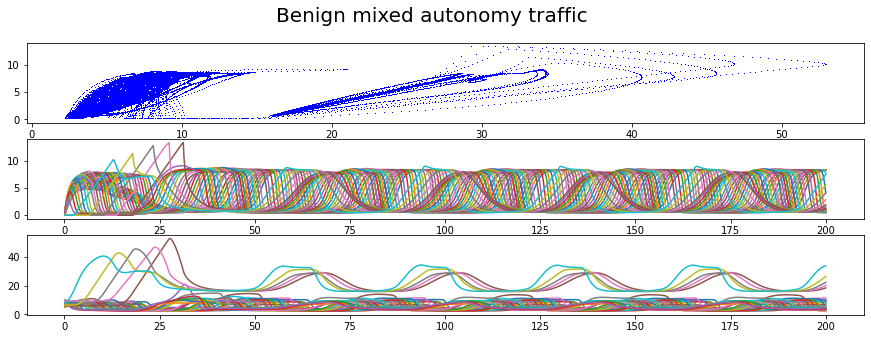

In [19]:
begin_time = 0.0
end_time = 500.0

veh_ids = (trajectory_dict_benign_mixed.keys())
fig = plt.figure(figsize=[15,5])

plt.subplot(3,1,1)

for veh_id in veh_ids:
    time = trajectory_dict_benign_mixed[veh_id][:,0]
    index_select = np.logical_and(time>begin_time,time<end_time)
    
    time = time[index_select]
    
    speed = trajectory_dict_benign_mixed[veh_id][:,1]
    spacing = trajectory_dict_benign_mixed[veh_id][:,2]
    
    speed = speed[index_select]
    spacing = spacing[index_select]
    
    plt.subplot(3,1,1)
    plt.plot(spacing,speed,'b,')
    
    plt.subplot(3,1,2)
    plt.plot(time,speed)
    
    plt.subplot(3,1,3)
    plt.plot(time,spacing)

fig.suptitle('Benign mixed autonomy traffic',fontsize=20)

In [75]:
# normalized_timeseries_list_benign_mixed,normalizing_factors_benign_mixed = make_timeseries_list_normalized(trajectory_dict_benign_mixed)

model_normalized = get_cnn_lstm_ae_model(n_features=4)
model_file_name = 'normalized_mixed_detector'
train_X = make_train_X(normalized_timeseries_list_benign_mixed)
print('Training data prepared.')

Training data prepared.


In [76]:
model_normalized = train_model(model_normalized,train_X,model_file_name)

Loaded existing model: /Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/test_detection_normalizing/models/cnn_lstm_ae_normalized_mixed_detector.pt
Best loss 0.42010180950164794
Beginning training.
Number epochs: 0 epoch step time: 2.636821746826172
Epoch 0, total loss 158.132569, total predictions 400, avg loss 0.395331 2023-01-20 08:23:33.257161
Saving model. Best loss: 0.39533142149448397
Number epochs: 1 epoch step time: 1.425482988357544
Number epochs: 2 epoch step time: 1.4383959770202637
Number epochs: 3 epoch step time: 1.3955397605895996
Number epochs: 4 epoch step time: 1.4079859256744385
Number epochs: 5 epoch step time: 1.3632628917694092
Epoch 5, total loss 212.749407, total predictions 400, avg loss 0.531874 2023-01-20 08:23:40.288535
Number epochs: 6 epoch step time: 1.3215110301971436
Number epochs: 7 epoch step time: 1.4978687763214111
Number epochs: 8 epoch step time: 1.3588051795959473
Number epochs: 9 epoch step time: 1.321930170059204
Number epochs: 10

Number epochs: 104 epoch step time: 1.4408881664276123
Number epochs: 105 epoch step time: 1.4422321319580078
Epoch 105, total loss 139.807590, total predictions 400, avg loss 0.349519 2023-01-20 08:26:07.789137
Number epochs: 106 epoch step time: 1.4590489864349365
Number epochs: 107 epoch step time: 1.484694004058838
Number epochs: 108 epoch step time: 1.5951869487762451
Number epochs: 109 epoch step time: 1.4504950046539307
Number epochs: 110 epoch step time: 1.6440839767456055
Epoch 110, total loss 191.579362, total predictions 400, avg loss 0.478948 2023-01-20 08:26:15.423216
Number epochs: 111 epoch step time: 1.5728583335876465
Number epochs: 112 epoch step time: 1.5824689865112305
Number epochs: 113 epoch step time: 1.5631790161132812
Number epochs: 114 epoch step time: 1.5625998973846436
Number epochs: 115 epoch step time: 1.5839731693267822
Epoch 115, total loss 141.842263, total predictions 400, avg loss 0.354606 2023-01-20 08:26:23.289148
Number epochs: 116 epoch step time:

In [78]:
absolute_values_timeseries_list_benign_mixed = make_timeseries_list(trajectory_dict_benign_mixed)

model_absolute_values = get_cnn_lstm_ae_model(n_features=4)
model_file_name = 'absolute_values_mixed_detector'
train_X = make_train_X(absolute_values_timeseries_list_benign_mixed)
print('Training data prepared.')

Training data prepared.


In [79]:
model_absolute_values = train_model(model_absolute_values,train_X,model_file_name)

Loaded existing model: /Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/test_detection_normalizing/models/cnn_lstm_ae_absolute_values_mixed_detector.pt
Best loss 10.157876415252685
Beginning training.
Number epochs: 0 epoch step time: 1.4679851531982422
Epoch 0, total loss 4270.937874, total predictions 400, avg loss 10.677345 2023-01-20 09:04:08.077937
Number epochs: 1 epoch step time: 1.4598209857940674
Number epochs: 2 epoch step time: 1.4426219463348389
Number epochs: 3 epoch step time: 1.4176278114318848
Number epochs: 4 epoch step time: 1.3482780456542969
Number epochs: 5 epoch step time: 1.400481939315796
Epoch 5, total loss 4796.480843, total predictions 400, avg loss 11.991202 2023-01-20 09:04:15.147451
Number epochs: 6 epoch step time: 1.37168288230896
Number epochs: 7 epoch step time: 1.3644590377807617
Number epochs: 8 epoch step time: 1.3677620887756348
Number epochs: 9 epoch step time: 1.3976340293884277
Number epochs: 10 epoch step time: 1.41068696975708
Ep

Number epochs: 104 epoch step time: 1.4843316078186035
Number epochs: 105 epoch step time: 1.4504141807556152
Epoch 105, total loss 3835.063850, total predictions 400, avg loss 9.587660 2023-01-20 09:06:41.047013
Number epochs: 106 epoch step time: 1.5688180923461914
Saving model. Best loss: 8.685443325042725
Number epochs: 107 epoch step time: 1.6554689407348633
Number epochs: 108 epoch step time: 1.4548799991607666
Number epochs: 109 epoch step time: 1.4859278202056885
Number epochs: 110 epoch step time: 1.6478779315948486
Epoch 110, total loss 3688.341759, total predictions 400, avg loss 9.220854 2023-01-20 09:06:48.860658
Number epochs: 111 epoch step time: 2.10627818107605
Saving model. Best loss: 7.920243492126465
Number epochs: 112 epoch step time: 1.6816809177398682
Number epochs: 113 epoch step time: 1.4838588237762451
Number epochs: 114 epoch step time: 1.7556841373443604
Number epochs: 115 epoch step time: 1.669424057006836
Epoch 115, total loss 4020.124100, total prediction

# Look at a few instances of attacks:

In [39]:
reload(misc)
from misc import sim_attacked_mixed

In [40]:
Total_Attack_Duration = 10.0
attack_decel_rate = -1.0

trajectory_dict_attacked_mixed, emission_path_attacked_mixed = sim_attacked_mixed(Total_Attack_Duration,attack_decel_rate)

Number of classes of driver: 39
Running ring simulation, ring length: 500
Spawning compromised ACC, attack frequency: 30.0
Will engage in multiple attacks.
Beginning attack: RDA_adv_TDA_10_ADR_-1.0_0 Time: 30.0
Attack finished:RDA_adv_TDA_10_ADR_-1.0_0, -1.0, 10, 40.1
Beginning attack: RDA_adv_TDA_10_ADR_-1.0_0 Time: 70.10000000000001
Attack finished:RDA_adv_TDA_10_ADR_-1.0_0, -1.0, 10, 80.2
Beginning attack: RDA_adv_TDA_10_ADR_-1.0_0 Time: 110.2
Attack finished:RDA_adv_TDA_10_ADR_-1.0_0, -1.0, 10, 120.30000000000001
Beginning attack: RDA_adv_TDA_10_ADR_-1.0_0 Time: 150.3
Attack finished:RDA_adv_TDA_10_ADR_-1.0_0, -1.0, 10, 160.4
Beginning attack: RDA_adv_TDA_10_ADR_-1.0_0 Time: 190.4


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 601.1060344652808
data/ring_variable_cfm_20230119-2319141674191954.350037-0_emission.csv data
Average, std velocities: 3.890026462760442, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 601.1060344652808, 0.0
Total time: 19.78568124771118
steps/second: 124.08493406921366
Data loaded, total time: 0.8951501846313477


In [91]:
absolute_values_timeseries_list_attacked_mixed = make_timeseries_list(trajectory_dict_attacked_mixed)

normalized_timeseries_list_attacked_mixed,normalizing_factors_attacked_mixed = make_timeseries_list_normalized(trajectory_dict_attacked_mixed,normalizing_factors_attacked_mixed)

print('Timeseries lists created.')

Timeseries lists created.


In [43]:
reload(misc)
from misc import get_losses_per_vehicle

time = np.arange(0.1,200.1,0.1)

losses_dict_absolute_values_attacked_mixed = get_losses_per_vehicle(absolute_values_timeseries_list_attacked_mixed,
                                                                    trajectory_dict_attacked_mixed,
                                                                    time,
                                                                    model_absolute_values)
print('Rec erorrs using absolute values extracted.')

Vehicles processed: 39

Rec erorrs using absolute values extracted.


In [92]:
losses_dict_normalized_attacked_mixed = get_losses_per_vehicle(normalized_timeseries_list_attacked_mixed,
                                                               trajectory_dict_attacked_mixed,
                                                               time,
                                                               model_normalized)
print('Rec erorrs using normalized values extracted.')

Vehicles processed: 39

Rec erorrs using normalized values extracted.


In [87]:
#benign data:

losses_dict_normalized_benign_mixed = get_losses_per_vehicle(normalized_timeseries_list_benign_mixed,
                                                               trajectory_dict_benign_mixed,
                                                               time,
                                                               model_normalized)
print('Rec erorrs using normalized values extracted.')

Vehicles processed: 40

Rec erorrs using normalized values extracted.


In [88]:
#benign data:

losses_dict_absolute_values_benign_mixed = get_losses_per_vehicle(absolute_values_timeseries_list_benign_mixed,
                                                               trajectory_dict_benign_mixed,
                                                               time,
                                                               model_absolute_values)
print('Rec erorrs using absolute values extracted.')

Vehicles processed: 40

Rec erorrs using absolute values extracted.


# Plot all reconstruction errors:

Text(0.5, 0.98, 'Single lane ring rec error comparison')

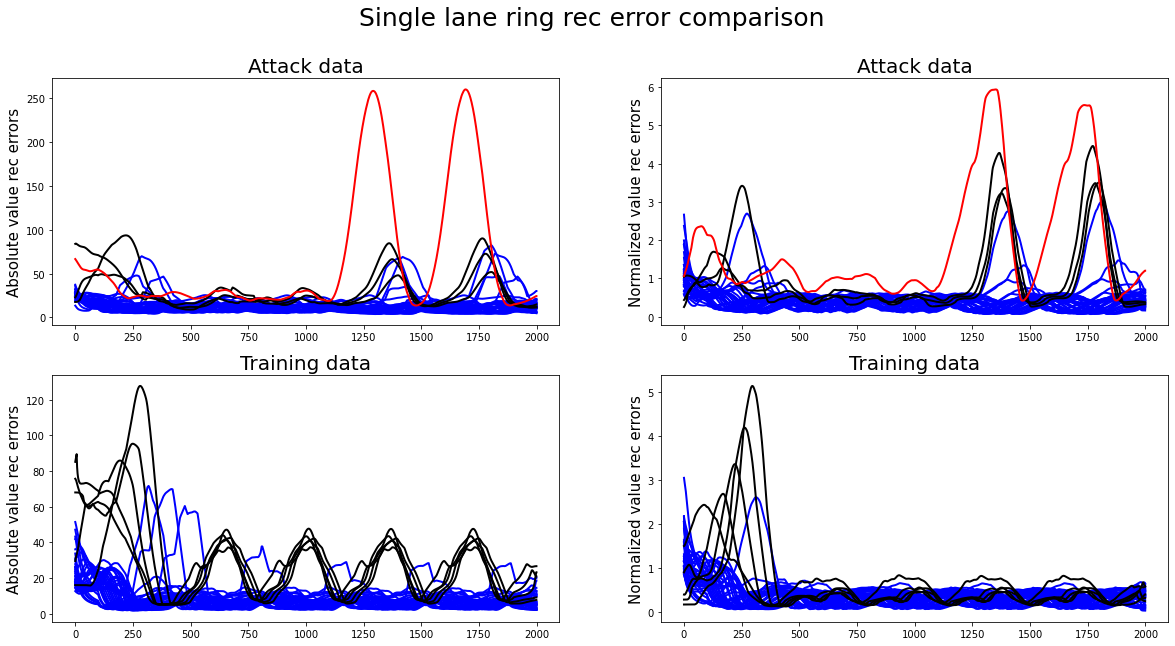

In [93]:
fig = plt.figure(figsize=[20,10])

plt.subplot(2,2,1)
for veh_id in losses_dict_absolute_values_attacked_mixed:
    rec_error = losses_dict_absolute_values_attacked_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Attack data',fontsize=20)
plt.ylabel('Absolute value rec errors',fontsize=15)


plt.subplot(2,2,2)
for veh_id in losses_dict_normalized_attacked_mixed:
    rec_error = losses_dict_normalized_attacked_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Attack data',fontsize=20)
plt.ylabel('Normalized value rec errors',fontsize=15)





plt.subplot(2,2,3)
for veh_id in losses_dict_absolute_values_benign_mixed:
    rec_error = losses_dict_absolute_values_benign_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Training data',fontsize=20)
plt.ylabel('Absolute value rec errors',fontsize=15)


plt.subplot(2,2,4)
for veh_id in losses_dict_normalized_benign_mixed:
    rec_error = losses_dict_normalized_benign_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Training data',fontsize=20)
plt.ylabel('Normalized value rec errors',fontsize=15)


fig.suptitle('Single lane ring rec error comparison',fontsize=25)

# Does a weaker attack make a difference?

In [95]:
reload(misc)

from misc import sim_attacked_mixed

Total_Attack_Duration = 5.0
attack_decel_rate = -0.25

trajectory_dict_attacked_mixed, emission_path_attacked_mixed = sim_attacked_mixed(Total_Attack_Duration,attack_decel_rate)

Number of classes of driver: 39
Running ring simulation, ring length: 500
Spawning compromised ACC, attack frequency: 30.0
Will engage in multiple attacks.
Beginning attack: RDA_adv_TDA_5.0_ADR_-0.25_0 Time: 30.0
Attack finished:RDA_adv_TDA_5.0_ADR_-0.25_0, -0.25, 5.0, 35.1
Beginning attack: RDA_adv_TDA_5.0_ADR_-0.25_0 Time: 65.10000000000001
Attack finished:RDA_adv_TDA_5.0_ADR_-0.25_0, -0.25, 5.0, 70.2
Beginning attack: RDA_adv_TDA_5.0_ADR_-0.25_0 Time: 100.2
Attack finished:RDA_adv_TDA_5.0_ADR_-0.25_0, -0.25, 5.0, 105.30000000000001
Beginning attack: RDA_adv_TDA_5.0_ADR_-0.25_0 Time: 135.3
Attack finished:RDA_adv_TDA_5.0_ADR_-0.25_0, -0.25, 5.0, 140.4
Beginning attack: RDA_adv_TDA_5.0_ADR_-0.25_0 Time: 170.4
Attack finished:RDA_adv_TDA_5.0_ADR_-0.25_0, -0.25, 5.0, 175.5


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 660.1432653839652
data/ring_variable_cfm_20230120-0945051674229505.467097-0_emission.csv data
Average, std velocities: 4.143835429097327, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 660.1432653839652, 0.0
Total time: 18.228710889816284
steps/second: 126.48757579575121
Data loaded, total time: 0.9611060619354248


In [98]:
absolute_values_timeseries_list_attacked_mixed = make_timeseries_list(trajectory_dict_attacked_mixed)

normalized_timeseries_list_attacked_mixed,normalizing_factors_attacked_mixed = make_timeseries_list_normalized(trajectory_dict_attacked_mixed,normalizing_factors_attacked_mixed)

print('Timeseries lists created.')


losses_dict_absolute_values_attacked_mixed = get_losses_per_vehicle(absolute_values_timeseries_list_attacked_mixed,
                                                                    trajectory_dict_attacked_mixed,
                                                                    time,
                                                                    model_absolute_values)
print('Rec erorrs using absolute values extracted.')

losses_dict_normalized_attacked_mixed = get_losses_per_vehicle(normalized_timeseries_list_attacked_mixed,
                                                               trajectory_dict_attacked_mixed,
                                                               time,
                                                               model_normalized)
print('Rec erorrs using normalized values extracted.')

Timeseries lists created.
Vehicles processed: 39

Rec erorrs using absolute values extracted.
Vehicles processed: 39

Rec erorrs using normalized values extracted.


Text(0.5, 0.98, 'Single lane ring rec error comparison')

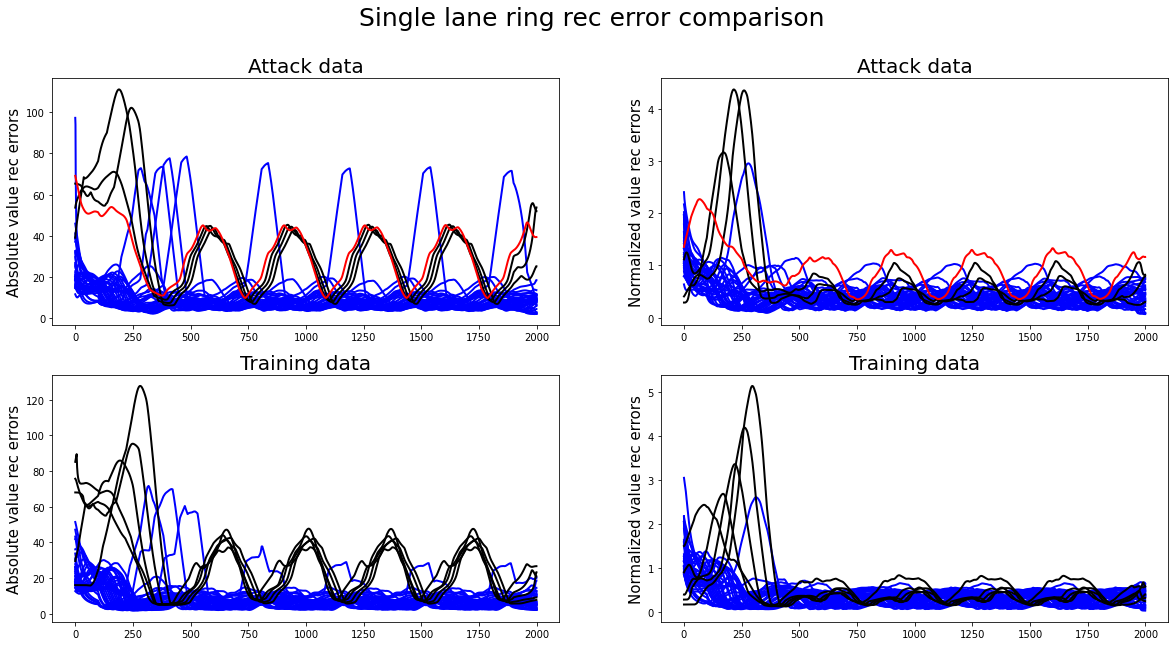

In [99]:
fig = plt.figure(figsize=[20,10])

plt.subplot(2,2,1)
for veh_id in losses_dict_absolute_values_attacked_mixed:
    rec_error = losses_dict_absolute_values_attacked_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Attack data',fontsize=20)
plt.ylabel('Absolute value rec errors',fontsize=15)


plt.subplot(2,2,2)
for veh_id in losses_dict_normalized_attacked_mixed:
    rec_error = losses_dict_normalized_attacked_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Attack data',fontsize=20)
plt.ylabel('Normalized value rec errors',fontsize=15)





plt.subplot(2,2,3)
for veh_id in losses_dict_absolute_values_benign_mixed:
    rec_error = losses_dict_absolute_values_benign_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Training data',fontsize=20)
plt.ylabel('Absolute value rec errors',fontsize=15)


plt.subplot(2,2,4)
for veh_id in losses_dict_normalized_benign_mixed:
    rec_error = losses_dict_normalized_benign_mixed[veh_id]
    if('RDA' in veh_id):
        plt.plot(rec_error,'r',linewidth=2.0)
    elif('ACC' in veh_id):
        plt.plot(rec_error,'k',linewidth=2.0)
    else:
        plt.plot(rec_error,'b',linewidth=2.0)
plt.title('Training data',fontsize=20)
plt.ylabel('Normalized value rec errors',fontsize=15)





fig.suptitle('Single lane ring rec error comparison',fontsize=25)

# Investigate instance of the I24 environment:

In [135]:
import detector_dev.Process_I24_simulations.i24_utils as i24_utils
reload(i24_utils)

i24_csv_path = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/Process_I24_simulations/misc_I24_data/I-24_benign.csv'

i24_benign_timeseries_dict = i24_utils.get_sim_timeseries(i24_csv_path)



Data loaded, total time: 59.79760193824768


In [136]:
normalized_timeseries_list_i24,normalizing_factors_i24 = make_timeseries_list_normalized(i24_benign_timeseries_dict)

print('Normalized training data extracted.')

Normalized training data extracted.


In [200]:
print(normalizing_factors_i24)

[ 30.          28.41799494 500.          23.09151303]


In [138]:
model_normalized = get_cnn_lstm_ae_model(n_features=4)
model_file_name = 'normalized_i24_detector'
train_X = make_train_X(normalized_timeseries_list_i24)
print('Training data prepared.')

model_normalized = train_model(model_normalized,train_X,model_file_name)

Training data prepared.
Loaded existing model: /Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/test_detection_normalizing/models/cnn_lstm_ae_normalized_i24_detector.pt
Best loss 1.7652577916335808
Beginning training.
Number epochs: 0 epoch step time: 105.74821496009827
Epoch 0, total loss 18622.810964, total predictions 30340, avg loss 0.613804 2023-01-23 14:54:23.345772
Saving model. Best loss: 0.6138039210161725
Number epochs: 1 epoch step time: 107.61689114570618
Number epochs: 2 epoch step time: 120.47832489013672
Saving model. Best loss: 0.5001971358166923
Number epochs: 3 epoch step time: 105.58714008331299
Saving model. Best loss: 0.40061050681354343
Number epochs: 4 epoch step time: 103.75720596313477
Saving model. Best loss: 0.3789045467216401
Number epochs: 5 epoch step time: 104.41931581497192
Epoch 5, total loss 10878.430837, total predictions 30340, avg loss 0.358551 2023-01-23 15:03:25.206923
Saving model. Best loss: 0.35855078565186393
Number epochs: 6 epo

KeyboardInterrupt: 

In [145]:
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat

from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth

from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder


def get_rec_errors_normalized(timeseries_dict,model,normalizing_factors=None,seq_len=100,warmup_period=1200):
    
    begin_time = time.time()

    veh_ids = list(timeseries_dict.keys())
   
    num_veh_processed = 0
    
    total_vehicles = len(veh_ids)

    testing_losses_dict = {}
        
    normalized_timeseries_list,normalizing_factors = make_timeseries_list_normalized(timeseries_dict,normalizing_factors)


    for veh_id in veh_ids:
        
        speed = timeseries_dict[veh_id][:,1]
        
        if(len(speed) > seq_len):
            # When not normalizing:
            
#             accel = np.gradient(speed,.1)
#             head_way = timeseries_dict[veh_id][:,2]
#             rel_vel = timeseries_dict[veh_id][:,3]

#             timeseries_list = [speed,accel,head_way,rel_vel]

            timeseries_list = normalized_timeseries_list[num_veh_processed]

            _,loss = sliding_window_mult_feat(model,timeseries_list)

            testing_losses_dict[veh_id]=loss

        num_veh_processed+=1

        if(num_veh_processed % 50 == 0):
            total_compute_time = time.time()-begin_time
            
            sys.stdout.write('\r'+'Vehicles processed: '+str(num_veh_processed)+'/'+str(total_vehicles)+', total compute time: '+str(total_compute_time)+'\r')
            
            
#             print('Vehicles processed: '+str(num_veh_processed)+'/'+str(total_vehicles)+', total compute time: '+str(total_compute_time))
        
    print('\n')
    
    smoothed_losses = {}
    
    #Get smoothed loss values:
    
    for veh_id in testing_losses_dict:
        loss = testing_losses_dict[veh_id]
        if(loss is not None):
            vehicles_time = timeseries_dict[veh_id][:,0]
            smoothed_losses[veh_id] =  [vehicles_time,loss_smooth(vehicles_time,loss)]
    
    print('Total time to calculate loses: '+str(time.time()-begin_time))
    
    return smoothed_losses


In [146]:
rec_errors_i24_normalized = get_rec_errors_normalized(timeseries_dict=i24_benign_timeseries_dict,
                                                      model=model_normalized,
                                                      normalizing_factors=normalizing_factors_i24,
                                                      warmup_period=600)

Vehicles processed: 3000/3034, total compute time: 4558.9255530834265

Total time to calculate loses: 4576.866844177246


In [147]:
i24_utils.write_losses_to_file(rec_errors_i24_normalized,file_name='i24_rec_errors_normalized.csv')

Loss file written to csv.


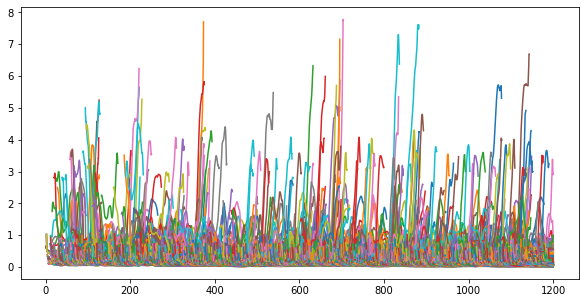

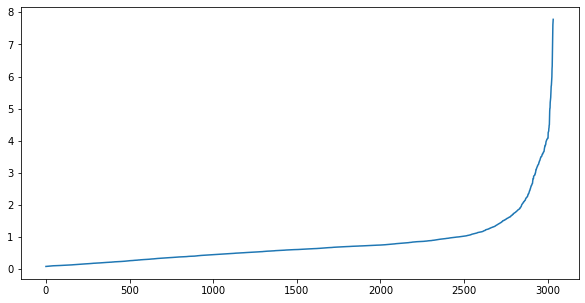

In [176]:
plt.figure(figsize=[10,5])

max_rec_errors = []

for veh_id in rec_errors_i24_normalized:
    max_rec_errors.append(np.max(rec_errors_i24_normalized[veh_id][1]))
    plt.plot(rec_errors_i24_normalized[veh_id][0],rec_errors_i24_normalized[veh_id][1])
    
plt.figure(figsize=[10,5])
plt.plot(np.sort(max_rec_errors),'.')

In [156]:
i24_attack_csv_path = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/Process_I24_simulations/misc_I24_data/Dur_45_Mag_-1.0_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1.csv'

i24_attack_timeseries_dict = i24_utils.get_sim_timeseries(i24_attack_csv_path,warmup_period=600.0)

print('Loaded attacked data.')

Data loaded, total time: 61.76834273338318
Loaded attacked data.


In [157]:
veh_types_attack_i24 = i24_utils.get_vehicle_types(i24_attack_csv_path)

In [161]:
i24_attack_timeseries_dict_attackers_only = {}


for veh_id in i24_attack_timeseries_dict:
    veh_type = veh_types_attack_i24[veh_id]
    if('attacker' in veh_type):
        i24_attack_timeseries_dict_attackers_only[veh_id] = i24_attack_timeseries_dict[veh_id]
        
        
normalized_timeseries_list_i24_attackers_only,normalizing_factors_i24 = make_timeseries_list_normalized(i24_attack_timeseries_dict_attackers_only,normalizing_factors_i24)

print('Normalized attack data created')

Normalized attack dats created


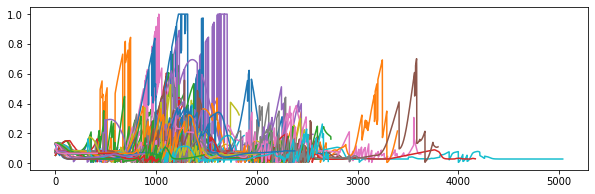

In [169]:
plt.figure(figsize=[10,3])
for t_list in normalized_timeseries_list_i24_attackers_only:
    plt.plot(t_list[2])

In [170]:
rec_errors_i24_attack_only_normalized = get_rec_errors_normalized(timeseries_dict=i24_attack_timeseries_dict_attackers_only,
                                                      model=model_normalized,
                                                      normalizing_factors=normalizing_factors_i24,
                                                      warmup_period=600)



Total time to calculate loses: 105.56871795654297


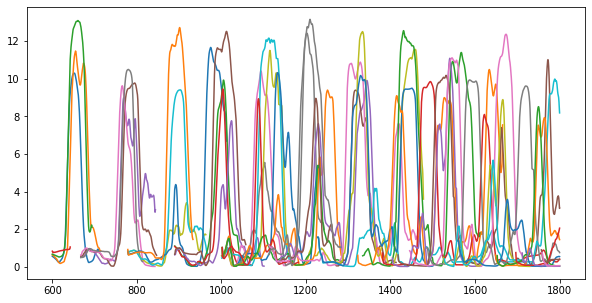

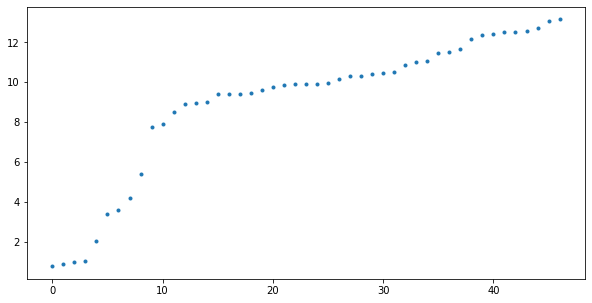

In [174]:
plt.figure(figsize=[10,5])

max_rec_errors_attackers = []

for veh_id in rec_errors_i24_attack_only_normalized:
    max_rec_errors_attackers.append(np.max(rec_errors_i24_attack_only_normalized[veh_id][1]))
    plt.plot(rec_errors_i24_attack_only_normalized[veh_id][0],rec_errors_i24_attack_only_normalized[veh_id][1])
 
plt.figure(figsize=[10,5])
plt.plot(np.sort(max_rec_errors_attackers),'.')

In [178]:
i24_attack_timeseries_dict_benign_only = {}

for veh_id in i24_attack_timeseries_dict:
    veh_type = veh_types_attack_i24[veh_id]
    if(not 'attacker' in veh_type):
        i24_attack_timeseries_dict_benign_only[veh_id] = i24_attack_timeseries_dict[veh_id]

In [183]:
num_rand_samples = 200

rand_sample_ints = np.random.randint(len(i24_attack_timeseries_dict_benign_only),size=num_rand_samples)

benign_veh_ids = list(i24_attack_timeseries_dict_benign_only.keys())

benign_sample_ids = []

for i in range(num_rand_samples):
    benign_sample_ids.append(benign_veh_ids[rand_sample_ints[i]])

In [185]:
i24_attack_timeseries_dict_benign_rand_sample = {}
for veh_id in benign_sample_ids:
    i24_attack_timeseries_dict_benign_rand_sample[veh_id] = i24_attack_timeseries_dict_benign_only[veh_id]
    

normalized_timeseries_list_i24_benign_rabnd_sample,normalizing_factors_i24 = make_timeseries_list_normalized(
    i24_attack_timeseries_dict_benign_rand_sample,
    normalizing_factors_i24)

print('Normalized benign samples data created')

Normalized benign samples data created


In [186]:
rec_errors_i24_benign_rand_sample_normalized = get_rec_errors_normalized(
    timeseries_dict=i24_attack_timeseries_dict_benign_rand_sample,
    model=model_normalized,
    normalizing_factors=normalizing_factors_i24,
    warmup_period=600)

Vehicles processed: 150/191, total compute time: 224.45686388015747

Total time to calculate loses: 295.4362690448761


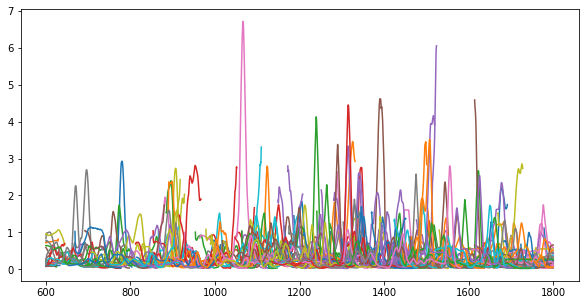

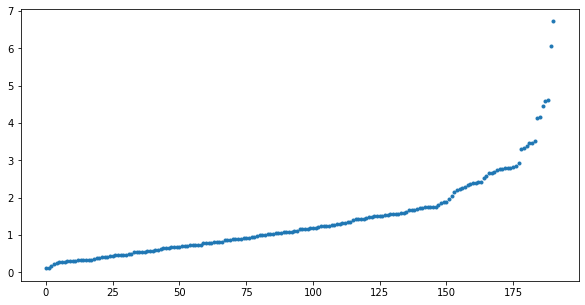

In [188]:
plt.figure(figsize=[10,5])

max_rec_errors_benign = []

for veh_id in rec_errors_i24_benign_rand_sample_normalized:
    max_rec_errors_benign.append(np.max(rec_errors_i24_benign_rand_sample_normalized[veh_id][1]))
    plt.plot(rec_errors_i24_benign_rand_sample_normalized[veh_id][0],
             rec_errors_i24_benign_rand_sample_normalized[veh_id][1])
 
plt.figure(figsize=[10,5])
plt.plot(np.sort(max_rec_errors_benign),'.')

In [189]:
rec_errors_i24_attack_normalized = get_rec_errors_normalized(
    timeseries_dict=i24_attack_timeseries_dict,
    model=model_normalized,
    normalizing_factors=normalizing_factors_i24,
    warmup_period=600)

Vehicles processed: 2650/2672, total compute time: 6844.1800692081455

Total time to calculate loses: 6863.214354276657


Text(0, 0.5, 'Maximum Reconstruction error')

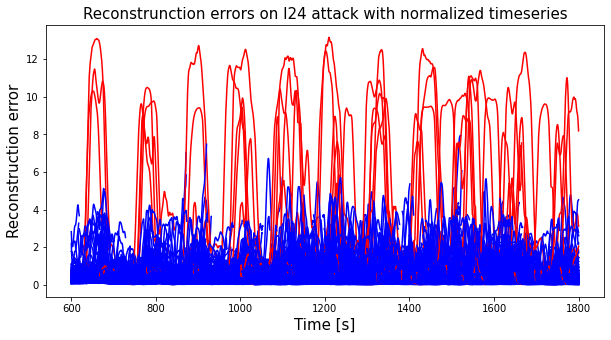

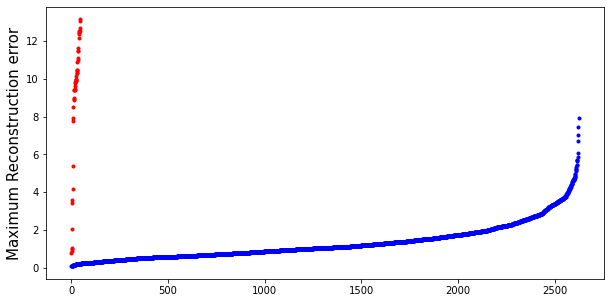

In [199]:
plt.figure(figsize=[10,5])

max_rec_errors_benign = []

max_rec_errors_malicious = []

mean_rec_errors_benign = []

mean_rec_errors_malicious = []

for veh_id in rec_errors_i24_attack_normalized:
    
    veh_type = veh_types_attack_i24[veh_id]
    
    if('attack' in veh_type):
        
        times = rec_errors_i24_attack_normalized[veh_id][0]
        rec_errors = rec_errors_i24_attack_normalized[veh_id][1]
    
        max_rec_errors_malicious.append(np.max(rec_errors))
            
        mean_rec_errors_malicious.append(np.mean(rec_errors))
        
        plt.plot(times,rec_errors,'r')
            
            
    else:
            
        times = rec_errors_i24_attack_normalized[veh_id][0]
        
        rec_errors = rec_errors_i24_attack_normalized[veh_id][1]
    
        max_rec_errors_benign.append(np.max(rec_errors))
            
        mean_rec_errors_benign.append(np.mean(rec_errors))
        
        plt.plot(times,rec_errors,'b') 

 
plt.title('Reconstrunction errors on I24 attack with normalized timeseries',fontsize=15)
plt.ylabel('Reconstruction error',fontsize=15)
plt.xlabel('Time [s]',fontsize=15)

plt.figure(figsize=[10,5])
plt.plot(np.sort(max_rec_errors_benign),'b.',label='Compromised ACC')
plt.plot(np.sort(max_rec_errors_malicious),'r.',label='Benign vehicles')
plt.ylabel('Maximum Reconstruction error',fontsize=15)




# plt.figure(figsize=[10,5])
# plt.plot(np.sort(mean_rec_errors_benign),'b.')
# plt.plot(np.sort(mean_rec_errors_malicious),'r.')

In [192]:
i24_utils.write_losses_to_file(rec_errors_i24_attack_normalized,file_name='Dur_45_Mag_-1.0_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1_rec_errors_normalized.csv')

Loss file written to csv.
